In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r"input/train.csv", parse_dates=['date'])
test = pd.read_csv(r"input/test.csv", parse_dates=['date'])


In [3]:
train

,date,store,item,sales
0,2018-01,0,0,109
1,2018-01,1,0,1
2,2018-01,2,0,182
3,2018-01,3,0,922
4,2018-01,4,0,130
...,...,...,...,...
102438,2022-52,2,49,117
102439,2022-52,3,49,204
102440,2022-52,9,49,203
102441,2022-52,4,49,188


In [4]:
df = pd.concat([train, test], sort=False)

In [5]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
df[["store"]].nunique()
df[["item"]].nunique()

item    50
dtype: int64

In [6]:
df.groupby(["store"])["item"].nunique()
df.groupby(["store", "item"]).agg({"sales": ["sum"]})
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                                  
                 sum         mean  median          std
store item                                            
0     0      52413.0   289.574586    60.0   617.740391
      1      65074.0   335.432990    47.0   845.662556
      2      30512.0   117.353846   113.0    42.327982
      3     159666.0   790.425743   183.5  1639.450553
      4      36894.0   141.900000   110.0   317.815307
...              ...          ...     ...          ...
9     45    107154.0   432.072581   415.5   165.617440
      46     86983.0   335.841699   259.0   279.046206
      47    588422.0  2391.959350  2508.5  1497.203079
      48     58491.0   225.833977   223.0    71.768790
      49     82493.0   317.280769   264.5   172.564470

[500 rows x 4 columns]

In [7]:
df['year'], df['week_of_year'] = zip(*df['date'].map(lambda x: x.split('-')))

In [8]:
df[['year', 'week_of_year']] = df[['year', 'week_of_year']].astype(int)

In [9]:
df.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128443 entries, 0 to 25999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          128443 non-null  object 
 1   store         128443 non-null  int64  
 2   item          128443 non-null  int64  
 3   sales         102443 non-null  float64
 4   id            26000 non-null   float64
 5   year          128443 non-null  int32  
 6   week_of_year  128443 non-null  int32  
dtypes: float64(2), int32(2), int64(2), object(1)
memory usage: 6.9+ MB


In [10]:
df.groupby(["store", "item", "year","week_of_year"]).agg({"sales": ["sum", "mean", "median", "std"]})

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [11]:
df.sort_values(by=['store', 'item', 'year','week_of_year'], axis=0, inplace=True)

In [12]:
df["sales"].head(10)

0       109.0
431      41.0
1316     51.0
1763     98.0
2208      1.0
3095    147.0
3533      3.0
5722     88.0
6154     62.0
7463     15.0
Name: sales, dtype: float64

In [13]:
df

,date,store,item,sales,id,year,week_of_year
0,2018-01,0,0,109.0,NaN,2018,1
431,2018-02,0,0,41.0,NaN,2018,2
1316,2018-04,0,0,51.0,NaN,2018,4
1763,2018-05,0,0,98.0,NaN,2018,5
2208,2018-06,0,0,1.0,NaN,2018,6
...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48
24499,2023-49,9,49,NaN,24499.0,2023,49
24999,2023-50,9,49,NaN,24999.0,2023,50
25499,2023-51,9,49,NaN,25499.0,2023,51


In [14]:
df["sales"].shift(1).values[0:10]
df["sales"].shift(2).values[0:10]
df["sales"].shift(3).values[0:10]

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,109.0,NaN,NaN,NaN,NaN
1,41.0,109.0,NaN,NaN,NaN
2,51.0,41.0,109.0,NaN,NaN
3,98.0,51.0,41.0,109.0,NaN
4,1.0,98.0,51.0,41.0,109.0
5,147.0,1.0,98.0,51.0,41.0
6,3.0,147.0,1.0,98.0,51.0
7,88.0,3.0,147.0,1.0,98.0
8,62.0,88.0,3.0,147.0,1.0
9,15.0,62.0,88.0,3.0,147.0


In [15]:
df.groupby(["store", "item"])['sales'].head()
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 456,546, 728,821])


df[df["sales"].isnull()]

,date,store,item,sales,id,year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821
0,2023-01,0,0,NaN,0.0,2023,1,3.874965,76.682060,44.522570,40.831672,33.286060,1608.373767,NaN,NaN,NaN,NaN,NaN,NaN
500,2023-02,0,0,NaN,500.0,2023,2,38.254143,6.627466,137.898294,132.885383,25.370542,1485.852135,108.482515,NaN,NaN,NaN,NaN,NaN
1000,2023-03,0,0,NaN,1000.0,2023,3,32.147142,15.124245,77.496003,224.234805,55.587371,22.232824,42.011853,NaN,NaN,NaN,NaN,NaN
1500,2023-04,0,0,NaN,1500.0,2023,4,41.547804,13.720763,54.562890,1.889723,1.891655,15.388338,50.941847,NaN,NaN,NaN,NaN,NaN
2000,2023-05,0,0,NaN,2000.0,2023,5,189.550906,5.824662,19.395601,131.994771,-0.926885,70.359941,96.962151,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48,694.662220,326.126541,239.352871,127.156928,318.123549,307.551272,103.946285,NaN,NaN,NaN,NaN,NaN
24499,2023-49,9,49,NaN,24499.0,2023,49,810.435850,278.075260,232.077628,207.565278,297.485663,347.359163,105.887572,NaN,NaN,NaN,NaN,NaN
24999,2023-50,9,49,NaN,24999.0,2023,50,643.225971,266.696331,244.671699,282.314010,244.167963,421.609588,139.233510,NaN,NaN,NaN,NaN,NaN
25499,2023-51,9,49,NaN,25499.0,2023,51,292.594079,352.594262,210.747254,268.959233,239.418479,327.066678,156.713178,NaN,NaN,NaN,NaN,NaN


In [16]:
df

,date,store,item,sales,id,year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821
0,2018-01,0,0,109.0,NaN,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2018-02,0,0,41.0,NaN,2018,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,2018-04,0,0,51.0,NaN,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1763,2018-05,0,0,98.0,NaN,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2208,2018-06,0,0,1.0,NaN,2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48,694.662220,326.126541,239.352871,127.156928,318.123549,307.551272,103.946285,NaN,NaN,NaN,NaN,NaN
24499,2023-49,9,49,NaN,24499.0,2023,49,810.435850,278.075260,232.077628,207.565278,297.485663,347.359163,105.887572,NaN,NaN,NaN,NaN,NaN
24999,2023-50,9,49,NaN,24999.0,2023,50,643.225971,266.696331,244.671699,282.314010,244.167963,421.609588,139.233510,NaN,NaN,NaN,NaN,NaN
25499,2023-51,9,49,NaN,25499.0,2023,51,292.594079,352.594262,210.747254,268.959233,239.418479,327.066678,156.713178,NaN,NaN,NaN,NaN,NaN


In [17]:
df["sales"].head(10)
df["sales"].rolling(window=2).mean().values[0:10]
df["sales"].rolling(window=3).mean().values[0:10]
df["sales"].rolling(window=5).mean().values[0:10]

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})


pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,109.0,NaN,NaN,NaN
1,41.0,NaN,NaN,NaN
2,51.0,75.0,NaN,NaN
3,98.0,46.0,67.000000,NaN
4,1.0,74.5,63.333333,NaN
5,147.0,49.5,50.000000,60.0
6,3.0,74.0,82.000000,67.6
7,88.0,75.0,50.333333,60.0
8,62.0,45.5,79.333333,67.4
9,15.0,75.0,51.000000,60.2


In [18]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 456,546])

In [19]:
df

,date,store,item,sales,id,year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546
0,2018-01,0,0,109.0,NaN,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2018-02,0,0,41.0,NaN,2018,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,2018-04,0,0,51.0,NaN,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1763,2018-05,0,0,98.0,NaN,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2208,2018-06,0,0,1.0,NaN,2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48,694.662220,326.126541,239.352871,127.156928,318.123549,307.551272,103.946285,NaN,NaN,NaN,NaN,NaN,303.276223,338.545607,358.241362
24499,2023-49,9,49,NaN,24499.0,2023,49,810.435850,278.075260,232.077628,207.565278,297.485663,347.359163,105.887572,NaN,NaN,NaN,NaN,NaN,302.717394,339.696342,359.748556
24999,2023-50,9,49,NaN,24999.0,2023,50,643.225971,266.696331,244.671699,282.314010,244.167963,421.609588,139.233510,NaN,NaN,NaN,NaN,NaN,302.710619,338.825449,359.465458
25499,2023-51,9,49,NaN,25499.0,2023,51,292.594079,352.594262,210.747254,268.959233,239.418479,327.066678,156.713178,NaN,NaN,NaN,NaN,NaN,300.302848,338.045567,357.267506


In [20]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})


def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [21]:
df

,date,store,item,sales,id,year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546
0,2018-01,0,0,109.0,NaN,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2018-02,0,0,41.0,NaN,2018,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,2018-04,0,0,51.0,NaN,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1763,2018-05,0,0,98.0,NaN,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2208,2018-06,0,0,1.0,NaN,2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48,694.662220,326.126541,239.352871,127.156928,318.123549,307.551272,103.946285,NaN,NaN,NaN,NaN,NaN,303.276223,338.545607,358.241362
24499,2023-49,9,49,NaN,24499.0,2023,49,810.435850,278.075260,232.077628,207.565278,297.485663,347.359163,105.887572,NaN,NaN,NaN,NaN,NaN,302.717394,339.696342,359.748556
24999,2023-50,9,49,NaN,24999.0,2023,50,643.225971,266.696331,244.671699,282.314010,244.167963,421.609588,139.233510,NaN,NaN,NaN,NaN,NaN,302.710619,338.825449,359.465458
25499,2023-51,9,49,NaN,25499.0,2023,51,292.594079,352.594262,210.747254,268.959233,239.418479,327.066678,156.713178,NaN,NaN,NaN,NaN,NaN,300.302848,338.045567,357.267506


In [22]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365,456,546, 728,821]

df = ewm_features(df, alphas, lags)

In [23]:
df

,date,store,item,sales,id,year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821
0,2018-01,0,0,109.0,NaN,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2018-02,0,0,41.0,NaN,2018,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316,2018-04,0,0,51.0,NaN,2018,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1763,2018-05,0,0,98.0,NaN,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2208,2018-06,0,0,1.0,NaN,2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,2023-48,9,49,NaN,23999.0,2023,48,694.662220,326.126541,239.352871,127.156928,318.123549,307.551272,103.946285,NaN,NaN,NaN,NaN,NaN,303.276223,338.545607,358.241362,678.299691,320.524091,240.668971,136.238490,140.006226,641.197965,NaN,NaN,NaN,NaN,NaN,661.740635,311.294612,241.336542,143.959918,138.029621,648.276585,NaN,NaN,NaN,NaN,NaN,629.204808,293.590560,242.4866

In [24]:
df = pd.get_dummies(df, columns=['store', 'item', 'year', 'week_of_year' ])

In [25]:
df

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,2018-01,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
431,2018-02,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
df['sales'] = np.log1p(df["sales"].values)

In [27]:
df

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,2018-01,4.700480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
431,2018-02,3.737670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [29]:
train = df.loc[(df["date"] < "2022"), :]

In [30]:
train

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,2018-01,4.700480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
431,2018-02,3.737670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [31]:
val = df.loc[(df["date"] >= "2022-52") & (df["date"] < "2023-01"), :]

In [32]:
val

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
102118,2022-52,3.737670,NaN,114.061612,127.652633,79.794434,87.874085,206.632503,95.488354,100.882629,NaN,NaN,NaN,NaN,NaN,125.771139,135.100720,130.150419,113.851677,124.745504,83.362124,82.420409,120.567921,NaN,NaN,NaN,NaN,NaN,NaN,113.714579,122.674146,85.556070,82.183496,120.074583,NaN,NaN,NaN,NaN,NaN,NaN,113.529024,119.036896,89.475414,82.751429,118.932326,NaN,NaN,NaN,NaN,NaN,NaN,113.550274,116.015235,92.810253,84.744447,117.642942,NaN,NaN,NaN,NaN,NaN,NaN,114.364674,111.678255,97.816621,93.527494,114.874600,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102128,2022-52,3.433987,NaN,89.086710,132.957548,100.082130,105.028717,101.997830,60.861752,127.400552,NaN,NaN,NaN,NaN,NaN,141.857451,147.384154

In [33]:
train = df.loc[(df["date"] < "2022"), :]
val = df.loc[(df["date"] >= "2022-52") & (df["date"] < "2023-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year", 'week_of_year']]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((82979,), (82979, 188), (332,), (332, 188))

In [34]:
train

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,2018-01,4.700480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
431,2018-02,3.737670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [35]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': None,
              'nthread': -1}

lgb_params =  { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 5,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'num_boost_round': 2000,
                'early_stopping_rounds': None,
                'min_child_weight' : 0.1,
                'nthread': -1}

In [36]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[100]	training's l1: 0.572089	training's SMAPE: 50.8132	valid_1's l1: 0.73463	valid_1's SMAPE: 61.0466
[200]	training's l1: 0.543911	training's SMAPE: 48.6772	valid_1's l1: 0.713229	valid_1's SMAPE: 60.0074
[300]	training's l1: 0.530086	training's SMAPE: 47.6425	valid_1's l1: 0.702028	valid_1's SMAPE: 59.3978
[400]	training's l1: 0.520498	training's SMAPE: 46.9291	valid_1's l1: 0.697386	valid_1's SMAPE: 59.1861
[500]	training's l1: 0.51318	training's SMAPE: 46.3787	valid_1's l1: 0.697155	valid_1's SMAPE: 59.2143
[600]	training's l1: 0.507189	training's SMAPE: 45.919	valid_1's l1: 0.695584	valid_1's SMAPE: 59.1217
[700]	training's l1: 0.501931	training's SMAPE: 45.5265	valid_1's l1: 0.694356	valid_1's SMAPE: 59.0474
[800]	training's l1: 0.497256	training's SMAPE: 45.1794	valid_1's l1: 0.694599	valid_1's SMAPE: 59.0896
[900]	

58.78442210839939

In [37]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

                        feature  split       gain
12          sales_roll_mean_365   1122  29.554098
14          sales_roll_mean_546    860  11.282406
13          sales_roll_mean_456    847  10.961376
89                       item_9    414   2.699749
130                   year_2018    380   2.585764
81                       item_1    374   1.952435
96                      item_16    113   1.677691
48    sales_ewm_alpha_07_lag_91    257   1.586522
169             week_of_year_34    221   1.438922
170             week_of_year_35    205   1.381627
127                     item_47    119   1.349555
83                       item_3    285   1.304428
87                       item_7    336   1.265882
80                       item_0    277   1.221902
168             week_of_year_33    184   1.134962
75                      store_5    170   0.999343
133                   year_2021    199   0.989670
167             week_of_year_32    151   0.960096
114                     item_34    269   0.769812


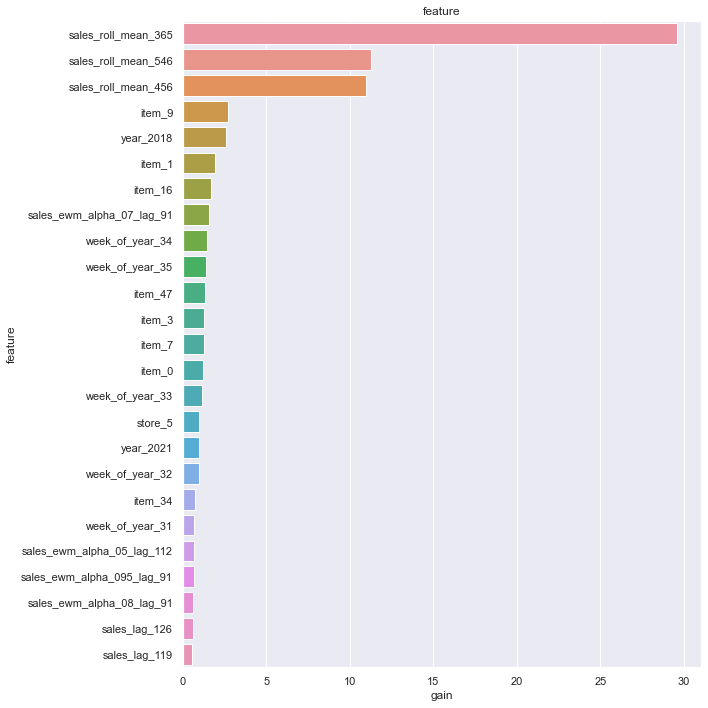

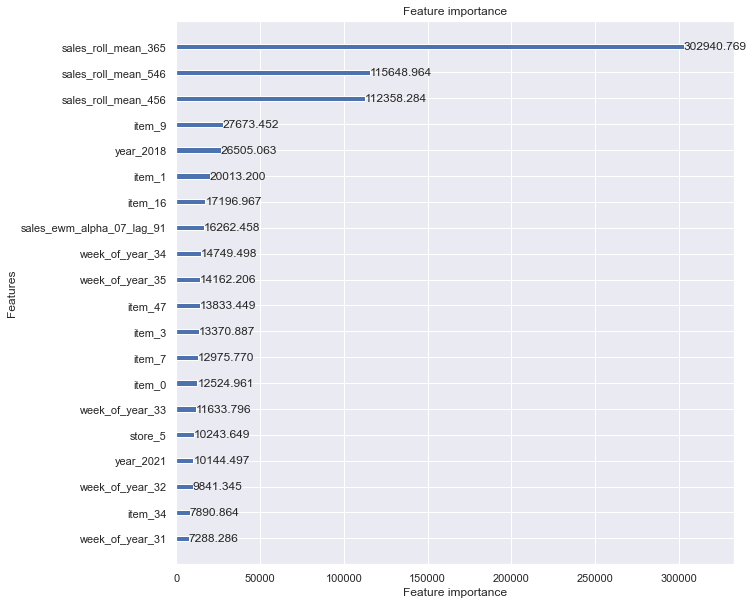

In [38]:
plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [39]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [40]:
lgb_params = { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 5,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'early_stopping_rounds': None,
                'min_child_weight' : 0.1,
                'nthread': -1,
              "num_boost_round": 2000}

In [ ]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

# Create submission
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.to_csv(r"output/submission_demand.csv", index=False)
submission_df.head(20)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032135 seconds.
You can set `force_col_wise=true` to remove the overhead.
